In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms

import os
import time
from tqdm import tqdm
import numpy as np

from models import *
import math
import random
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
#net_test = torch.nn.DataParallel(net_test,device_ids=[0,1]).cuda()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model
# print('==> Building model..')
# net = ResNet50()
# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
# net = EfficientNetB0()
# net = VGG('VGG16')


#net = net.to(device)

# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

#optimizer = optim.Adam(net.parameters(),lr=0.001)
#optimizer = optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

def easy_test():
    net_test.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net_test(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print('TestLoss: %.3f | TestAcc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

        # Save checkpoint.
        acc = 100.*correct/total
    return acc

/home/user/anaconda3/envs/torch1.7/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(torch.cuda.current_device())
torch.__version__

0


'1.7.1'

In [4]:
fab=[1,1,1]
for i in range(40):
    fab.append(fab[i+2]+fab[i+1])
print(fab)

def getA(r):
    A = np.array([[fab[2*r-1],fab[2*r]],[fab[2*r],fab[2*r+1]]])
    return A

def getB(r):
    B = np.array([[fab[2*r+1],-1*fab[2*r]],[-1*fab[2*r],fab[2*r-1]]])
    return B

def map(x,y,A):
    ori = np.array([[x],[y]])
    fin = np.dot(A,ori)
    return fin

def acm(bef,r,s):
    #new = torch.zeros_like(bef.data)
    new = bef.clone()
    if r>=0:
        A = getA(r)
    else:
        A = getB(-1*r)
    if s <= min(bef.shape[0],bef.shape[1]):
         for i in range(s):
             for j in range(s):
                 fin = map(i,j,A)
                 new[fin[0][0]%s][fin[1][0]%s] = bef[i][j]
                 #print('(',fin[0][0]%s,',',fin[1][0]%s,')','(',i,',',j,')')
    else:
        print("s is out of limit.")
    return new         

def map1(x,y,A):
    ori = np.array([x,y])
    fin = np.dot(A,ori)
    return fin

def acm1(bef,r,s):
    #new = torch.zeros_like(bef.data)
    new = bef.clone()
    if r>=0:
        A = getA(r)
    else:
        A = getB(-1*r)
    if s <= min(bef.shape[0],bef.shape[1]):
        fin = []
        for i in range(s):
            x = [i]*s
            y = []
            for j in range(s):
                y.append(j)
            fin.append(map1(x,y,A))  

        for i in range(s):
            for j in range(s):
                new[fin[i][0][j]%s][fin[i][1][j]%s] = bef[i][j]
                #print('(',fin[0][0]%s,',',fin[1][0]%s,')','(',i,',',j,')')
    else:
        print("s is out of limit.")
    return new          


def acm2(bef,r,percent=1):
    new = bef.clone()
    bef = bef.cpu()
    new = new.cpu()
    if r>=0:
        A = getA(r)
    else:
        A = getB(-1*r)
    
    s = min(bef.shape[0],bef.shape[1])
    s = int(s*percent)
    fin_x = []
    fin_y = []
    for i in range(s):
        x = [i]*s
        y = range(s)
        ret = map1(x,y,A)
        fin_x.extend(ret[0])
        fin_y.extend(ret[1])
    
    cnt=0
    for i in range(s):
        for j in range(s):
            new[fin_x[cnt]%s][fin_y[cnt]%s] = bef[i][j]
            cnt = cnt+1
            #print('(',fin[0][0]%s,',',fin[1][0]%s,')','(',i,',',j,')')
    
    return new   

 
def acm3(bef,r,percent=1):#can't use
    new = bef.clone()
    bef = bef.cpu()
    new = new.cpu()
    if r>=0:
        A = getA(r)
    else:
        A = getB(-1*r)
    
    s = min(bef.shape[0],bef.shape[1])
    s = int(s*percent)
    fin_xy = []

    for i in range(s):
        x = [i]*s
        y = range(s)
        ret = map1(x,y,A)
        x1 = ret[0]
        y1 = ret[1]
        xy = []
        for j in range(s):
            xy.append(torch.tensor([x1[j],y1[j]]))
        fin_xy.append(xy)

    for i in range(s):
        new.index_put(indices=fin_xy[i],values=bef[i])
    
    return new       


[1, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465, 14930352, 24157817, 39088169, 63245986, 102334155, 165580141, 267914296]


In [5]:
import math
import random
def factor(nb,na):
    factors = []
    for_times = int(math.sqrt(nb))
    for i in range(for_times + 1)[1:]:
        if nb % i == 0:
            if na * i % nb == 0:
                factors.append(i)
            t = int(nb / i)
            if t != i and na * t % nb == 0:
                factors.append(t)
    factors.sort()
    return factors
 
def backer(bef,nlist):
    na = bef.shape[0]
    nb = bef.shape[1]
    new = bef.clone()
    Ni = 0
    r0 = 0; s0 = 0
    for ni in nlist:
        qi = int(nb/ni)
        for k in range(int(na/qi)):
            rtemp = r0
            for i in range(ni):    
                stemp = s0            
                r1 = int( qi * ( r0 - Ni ) + s0 % qi)
                s1 = int( ( s0 - s0 % qi )/qi + na / nb * Ni ) 
                for j in range(qi):
                    #print(r0,',',s0,'->',r1,',',s1)
                    new[s1][r1] = bef[s0][r0]
                    s0 = s0 + 1
                    r1 = r1 + 1
                r0 = r0 + 1
                s0 = stemp
            r0 = rtemp
            s0 = s0 + qi
        Ni = Ni + ni
        r0 = r0 + ni
        s0 = 0
    return new



def backer_inverse(bef,nlist):
    na = bef.shape[0]
    nb = bef.shape[1]
    new = bef.clone()
    Ni = 0
    r0 = 0; s0 = 0
    for ni in nlist:
        qi = int(nb/ni)
        for k in range(int(na/qi)):
            rtemp = r0
            for i in range(ni):    
                stemp = s0            
                r1 = int( qi * ( r0 - Ni ) + s0 % qi)
                s1 = int( ( s0 - s0 % qi )/qi + na / nb * Ni ) 
                for j in range(qi):
                    #print(r0,',',s0,'->',r1,',',s1)
                    new[s0][r0]=bef[s1][r1] 
                    s0 = s0 + 1
                    r1 = r1 + 1
                r0 = r0 + 1
                s0 = stemp
            r0 = rtemp
            s0 = s0 + qi
        Ni = Ni + ni
        r0 = r0 + ni
        s0 = 0
    return new

def backer_makenlist(bef,num=10):
    na = bef.shape[0]
    nb = bef.shape[1]
    # if na>nb :
    #     na,nb = nb,na
    factors = factor(nb,na)
    # if len(factors)>1 :
    #     factors = factors[1:]
    # nb>na 限制最小的ni
    if nb > na :
        nmin = int(nb/na)
        for i in range(len(factors)):
            if factors[i] >= nmin:
                factors = factors[i:]
                break
   
    if len(factors)>1 :
        factors=factors[:-1]
    factorstemp = factors
    nlist = []
    nbtemp = nb
    while nbtemp != 0 :
        newn = random.choice(factorstemp)
        while newn > nbtemp :
            factorstemp.remove(newn)
            newn = random.choice(factorstemp)
        nlist.append(newn)
        nbtemp = nbtemp - newn
    #print("len:",len(nlist))
    #print(nlist)
    return nlist




def backer1(bef,nlist):
    na = bef.shape[0]
    nb = bef.shape[1]
    new = bef.clone()
    
    new = new.cpu()
    bef = bef.cpu()
    #tempk = torch.zeros_like(bef[0][0])

    start_time=time.time()
    Ni = 0
    r0 = 0; s0 = 0
    for ni in nlist:
        qi = int(nb/ni)
        for k in range(int(na/qi)):
            rtemp = r0
            for i in range(ni):    
                stemp = s0            
                r1 = int( qi * ( r0 - Ni ) + s0 % qi)
                s1 = int( ( s0 - s0 % qi )/qi + na / nb * Ni ) 
                for j in range(qi):
                    #print(r0,',',s0,'->',r1,',',s1)
                    new[s1][r1] = bef[s0][r0]
                    #new[s1][r1] = tempk
                    s0 = s0 + 1
                    r1 = r1 + 1
                r0 = r0 + 1
                s0 = stemp
            r0 = rtemp
            s0 = s0 + qi
        Ni = Ni + ni
        r0 = r0 + ni
        s0 = 0
    end_time=time.time()
    print(end_time-start_time)

    return new

def backer2(bef,nlist):
    if bef.shape[1]==3:
        new = bef.clone()

        nb = bef.shape[0]
        na = bef.shape[1]

        new = new.cpu()
        bef = bef.cpu()

        Ni = 0
        r0 = 0; s0 = 0
        r1 = 0; s1 = 0
        for ni in nlist:
            qi = int(nb/ni)
            for k in range(int(na/qi)):
                stemp = s0
                for i in range(ni):    
                    rtemp = r0            

                    for j in range(qi):
                        new[s1][r1] = bef[s0][r0]
                        r0 = r0 + 1
                        s1 = s1 + 1
                        if s1==nb:
                            s1 = 0
                            r1 = r1 + 1
                    s0 = s0 + 1
                    r0 = rtemp

                s0 = stemp
                r0 = r0 + qi

            stemp = s0
            for i in range(ni):    
                rtemp = r0            
                for j in range(na-rtemp):
                    new[s1][r1] = bef[s0][r0]
                    r0 = r0 + 1
                    s1 = s1 + 1
                    if s1==nb:
                        s1 = 0
                        r1 = r1 + 1   
                s0 = s0 + 1
                r0 = rtemp
            s0 = stemp
            
            Ni = Ni + ni
            s0 = s0 + ni
            r0 = 0


    else:
        na = bef.shape[0]
        nb = bef.shape[1]

        new = bef.clone()
        new = new.cpu()
        bef = bef.cpu()
        #tempk = torch.zeros_like(bef[0][0])
        bef2 = torch.transpose(bef,0,1)
        # start_time=time.time()
        Ni = 0
        r0 = 0; s0 = 0
        for ni in nlist:
            qi = int(nb/ni)
            for k in range(int(na/qi)):
                rtemp = r0
                for i in range(ni):    
                    #stemp = s0            
                    r1 = int( qi * ( r0 - Ni ) + s0 % qi)
                    s1 = int( ( s0 - s0 % qi )/qi + na / nb * Ni ) 
                
                    #print(r0,',',s0,'->',r1,',',s1)
                    new[s1][r1:r1+qi] = bef2[r0][s0:s0+qi]
                    #new[s1][r1] = tempk

                    r0 = r0 + 1
                    #s0 = stemp
                r0 = rtemp
                s0 = s0 + qi
            Ni = Ni + ni
            r0 = r0 + ni
            s0 = 0


    return new

def backer_inverse2(bef,nlist):
    na = bef.shape[0]
    nb = bef.shape[1]

    new = bef.clone()
    new = new.cpu()
    bef = bef.cpu()

    #tempk = torch.zeros_like(bef[0][0])
    new = torch.transpose(new,0,1)
    
    Ni = 0
    r0 = 0; s0 = 0
    for ni in nlist:
        qi = int(nb/ni)
        for k in range(int(na/qi)):
            rtemp = r0
            for i in range(ni):    
                stemp = s0            
                r1 = int( qi * ( r0 - Ni ) + s0 % qi)
                s1 = int( ( s0 - s0 % qi )/qi + na / nb * Ni ) 
             
                #new[s1][r1:r1+qi] = bef2[r0][s0:s0+qi]
                new[r0][s0:s0+qi] = bef[s1][r1:r1+qi]
                #new[s0][r0]=bef[s1][r1] 

                r0 = r0 + 1
                s0 = stemp
            r0 = rtemp
            s0 = s0 + qi
        Ni = Ni + ni
        r0 = r0 + ni
        s0 = 0
    
    new = torch.transpose(new,0,1)

    return new


In [6]:
from torch.utils.data import random_split
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

train_size = int(0.05*len(trainset))
trainset_5,_ = random_split(
    dataset=trainset,
    lengths=[train_size,len(trainset)-train_size],
    generator=torch.Generator().manual_seed(0)
)
trainloader_5 = torch.utils.data.DataLoader(trainset_5, batch_size=128, shuffle=True, num_workers=2)

train_size = int(0.1*len(trainset))
trainset_10,_ = random_split(
    dataset=trainset,
    lengths=[train_size,len(trainset)-train_size],
    generator=torch.Generator().manual_seed(0)
)
trainloader_10 = torch.utils.data.DataLoader(trainset_10, batch_size=128, shuffle=True, num_workers=2)

train_size = int(0.15*len(trainset))
trainset_15,_ = random_split(
    dataset=trainset,
    lengths=[train_size,len(trainset)-train_size],
    generator=torch.Generator().manual_seed(0)
)
trainloader_15 = torch.utils.data.DataLoader(trainset_15, batch_size=128, shuffle=True, num_workers=2)

train_size = int(0.2*len(trainset))
trainset_20,_ = random_split(
    dataset=trainset,
    lengths=[train_size,len(trainset)-train_size],
    generator=torch.Generator().manual_seed(0)
)
trainloader_20 = torch.utils.data.DataLoader(trainset_20, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified


In [7]:
import matplotlib.pyplot as plt

In [8]:
def train2(epoch,trainloader):
    print('Epoch {}/{}'.format(epoch + 1,100))
    print('-' * 10)
    start_time = time.time()
    net_test.train()
    train_loss = 0
    train_loss_array=[]
    train_acc = 0
    correct = 0
    total = 0
    #with torch.no_grad():
    with tqdm(total=len(trainloader),desc='',postfix='') as pbar:
        pbar.ncols = 100
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            # 设置进度条左边的显示的信息
            pbar.set_description("Batch: %d" % (batch_idx+1))
            optimizer.zero_grad()
            outputs = net_test(inputs)
            loss = criterion(outputs, targets)
            loss.backward()                
            optimizer.step()

            train_loss += loss.item()
            train_loss_array.append(loss.item())
            _, predicted = outputs.max(1)
            #_, predicted = torch.max(outputs.data,1)
           # print(predicted,'-',targets)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            train_acc = 100. * correct / total
            
                # 设置进度条右边显示的信息
            
            pbar.set_postfix( loss=np.average(train_loss_array),train_acc = '%.3f%%'%(train_acc) )
            pbar.update(1)
    pbar.close()
    
    end_time = time.time()
    
    print('TrainLoss: %.3f | TrainAcc: %.3f%% (%d/%d) | Time Elapsed %.3f sec' % (train_loss/(batch_idx+1), 100.*correct/total, correct, total, end_time-start_time))

def test2(epoch,name):
    global best_acc
    net_test.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net_test(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
           # _, predicted = torch.max(outputs.data,1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print('TestLoss: %.3f | TestAcc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(net_test.state_dict(), './checkpoint/'+name+'_'+str(acc)+'.pth')
        best_acc = acc

In [9]:
net_test = VGG('VGG16')
net_test = torch.nn.DataParallel(net_test)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net_test.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)



In [10]:
# #挑选最优baker
# #测量加密单一层效率
# f = open('baker_vgg16_bestkey_300.txt' , 'w', encoding='gbk')

# net_test = VGG("VGG16")
# net_test = net_test.to(device)
# net_test = torch.nn.DataParallel(net_test)
# dir_name='./checkpoint/vgg16_92.24.pth'

# weight_name=[]

# dict = torch.load(dir_name)

# # VGG16 卷积层抽取
# feature_num = [0,3,7,10,14,17,20,24,27,30,34,37,40]

# for name in net_test.state_dict():
#     #print(name)
#     if name[-6:] == 'weight':
#         split_name = name.split('.')
#         if split_name[1]=='features' and int(split_name[2]) in feature_num:
#         #if name[-12:-8] == 'conv':
#             weight_name.append(name)
# print("layer num:",len(weight_name))


# acm_time_1 = []
# acm_acc_1 = []
# backer_time_1 = []
# backer_acc_1 = []
# layer_1=[]

# acm_time_2 = []
# acm_acc_2 = []
# backer_time_2 = []
# backer_acc_2 = []
# layer_2=[]

# nlist_set=[]
# i=0
# temp_acm_acc=0
# temp_backer_acc=0
# min_backer_time=0
# best_nlist=[]

# for name in weight_name:
#     i=i+1
#     dict = torch.load(dir_name)
#     print(name)
#     a = dict[name].clone()
#     print(a.shape)
#     min_backer_acc=100
#     for k in range(300):
#         nlist = backer_makenlist(a)
#         start_time = time.time()
#         new = backer2(a,nlist)
#         end_time = time.time()
#         t1 = end_time - start_time
#         dict[name] = new
#         net_test.load_state_dict(dict)
#         temp_backer_acc = easy_test()
#         if temp_backer_acc<min_backer_acc:
#             min_backer_acc=temp_backer_acc
#             min_backer_time=t1
#             best_nlist=nlist
#     nlist_set.append(best_nlist)

#     if a.shape[0]==a.shape[1]:
#         layer_1.append(i)

#         start_time = time.time()
#         new = acm2(a,5)
#         end_time = time.time()
#         t2 = end_time - start_time
#         print("acm:",t2)
#         acm_time_1.append(t2)
#         dict[name] = new
#         net_test.load_state_dict(dict)
#         temp_acm_acc=easy_test()
#         acm_acc_1.append(temp_acm_acc)


#         backer_time_1.append(min_backer_time)
#         backer_acc_1.append(min_backer_acc)
#         print("backer:",min_backer_time)
#         print('')

#         print(round((t2-min_backer_time)/t2*100,2),'%')
#         print('='*40)
#     else:
#         layer_2.append(i)
        
#         print("backer:",min_backer_time)
#         backer_time_2.append(min_backer_time)
#         backer_acc_2.append(min_backer_acc)
#         print('')

#         start_time = time.time()
#         new = acm2(a,5)
#         end_time = time.time()
#         t2 = end_time - start_time
#         print("acm:",t2)
#         acm_time_2.append(t2)
#         dict[name] = new
#         net_test.load_state_dict(dict)
#         acm_acc_2.append(easy_test())

#         print(round((t2-min_backer_time)/t2*100,2),'%')
#         print('='*40)

# f.write(str(nlist_set))
# f.flush()

In [11]:
nlist_set=[[32,32], [8, 1, 16, 1, 2, 1, 32, 2, 1], [4, 32, 1, 4, 1, 2, 4, 2, 1, 2, 1, 2, 1, 1, 4, 1, 1], [16, 16, 1, 4, 8, 1, 4, 32, 16, 8, 1, 2, 4, 8, 4, 2, 1], [16, 16, 64, 32], [16, 128, 1, 4, 32, 16, 1, 4, 16, 2, 1, 8, 8, 2, 16, 1], [128, 2, 2, 16, 8, 8, 1, 32, 1, 1, 1, 32, 2, 16, 1, 2, 1, 2], [4, 16, 2, 128, 16, 1, 4, 16, 16, 8, 32, 2, 2, 2, 1, 2, 1, 2, 1], [2, 128, 32, 4, 128, 1, 2, 8, 4, 32, 8, 32, 4, 16, 16, 32, 2, 32, 16, 8, 2, 1, 1, 1], [1, 64, 32, 256, 2, 32, 64, 4, 16, 4, 32, 4, 1], [8, 2, 64, 4, 256, 4, 64, 16, 4, 32, 32, 16, 4, 1, 1, 1, 2, 1], [4, 4, 128, 256, 16, 8, 64, 4, 2, 8, 8, 1, 8, 1], [8, 256, 1, 128, 4, 64, 8, 8, 32, 1, 2]]

In [12]:
#测量加密单一层效率

net_test = VGG("VGG16")
net_test = net_test.to(device)
net_test = torch.nn.DataParallel(net_test)
dir_name='./checkpoint/vgg16_92.24.pth'


dict = torch.load(dir_name)
weight_name=[]


# VGG16 卷积层抽取
feature_num = [0,3,7,10,14,17,20,24,27,30,34,37,40]

for name in net_test.state_dict():
    #print(name)
    if name[-6:] == 'weight':
        split_name = name.split('.')
        if split_name[1]=='features' and int(split_name[2]) in feature_num:
        #if name[-12:-8] == 'conv':
            weight_name.append(name)
print("layer num:",len(weight_name))

acm_time_1 = []
acm_acc_1 = []
backer_time_1 = []
backer_acc_1 = []
layer_1=[]

acm_time_2 = []
acm_acc_2 = []
backer_time_2 = []
backer_acc_2 = []
layer_2=[]

i=0
temp_acm_acc=0
temp_backer_acc=0

for name in weight_name:
    i=i+1
    dict = torch.load(dir_name)
    print(name)
    a = dict[name].clone()
    print(a.shape)

    if a.shape[0]==a.shape[1]:
        layer_1.append(i)

        start_time = time.time()
        new = backer2(a,nlist_set[i-1])
        end_time = time.time()
        t1 = end_time - start_time
        print("backer:",t1)
        backer_time_1.append(t1)
        dict[name] = new
        net_test.load_state_dict(dict)
        backer_acc_1.append(easy_test())
        print('')

        start_time = time.time()
        new = acm2(a,5)
        end_time = time.time()
        t2 = end_time - start_time
        print("acm:",t2)
        acm_time_1.append(t2)
        dict[name] = new
        net_test.load_state_dict(dict)
        acm_acc_1.append(easy_test())
        print(round((t2-t1)/t2*100,2),'%')
        print('='*40)
    else:
        layer_2.append(i)
        start_time = time.time()
        new = backer2(a,nlist_set[i-1])
        end_time = time.time()
        t1 = end_time - start_time
        print("backer:",t1)
        backer_time_2.append(t1)
        dict[name] = new
        net_test.load_state_dict(dict)
        backer_acc_2.append(easy_test())
        print('')

        start_time = time.time()
        new = acm2(a,5)
        end_time = time.time()
        t2 = end_time - start_time
        print("acm:",t2)
        acm_time_2.append(t2)
        dict[name] = new
        net_test.load_state_dict(dict)
        acm_acc_2.append(easy_test())
        print(round((t2-t1)/t2*100,2),'%')
        print('='*40)


layer num: 13
module.features.0.weight
torch.Size([64, 3, 3, 3])
backer: 0.002049684524536133
TestLoss: 5.324 | TestAcc: 26.790% (2679/10000)

acm: 0.0013668537139892578
TestLoss: 0.482 | TestAcc: 91.230% (9123/10000)
-49.96 %
module.features.3.weight
torch.Size([64, 64, 3, 3])
backer: 0.015960693359375
TestLoss: 6.486 | TestAcc: 9.750% (975/10000)

acm: 0.0530545711517334
TestLoss: 6.717 | TestAcc: 10.610% (1061/10000)
69.92 %
module.features.7.weight
torch.Size([128, 64, 3, 3])
backer: 0.02586817741394043
TestLoss: 8.570 | TestAcc: 7.180% (718/10000)

acm: 0.05494952201843262
TestLoss: 3.664 | TestAcc: 45.320% (4532/10000)
52.92 %
module.features.10.weight
torch.Size([128, 128, 3, 3])
backer: 0.023961544036865234
TestLoss: 5.054 | TestAcc: 7.080% (708/10000)

acm: 0.18933796882629395
TestLoss: 5.378 | TestAcc: 12.720% (1272/10000)
87.34 %
module.features.14.weight
torch.Size([256, 128, 3, 3])
backer: 0.1286172866821289
TestLoss: 6.313 | TestAcc: 7.560% (756/10000)

acm: 0.18952202796

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2]
2.7894136905670166


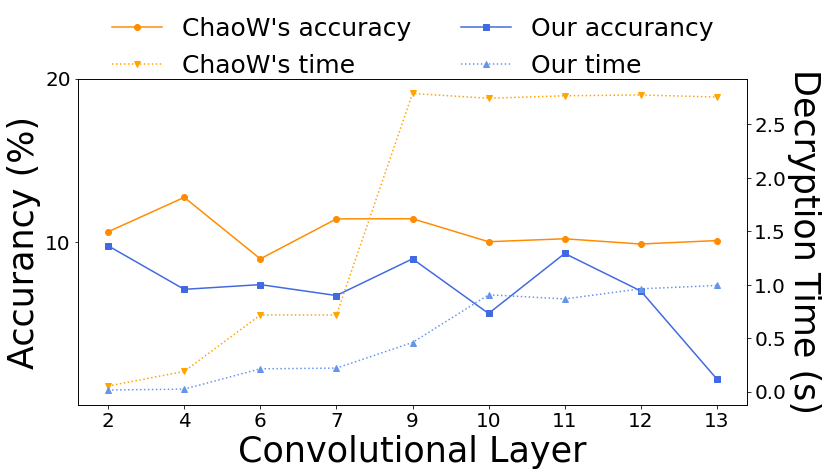

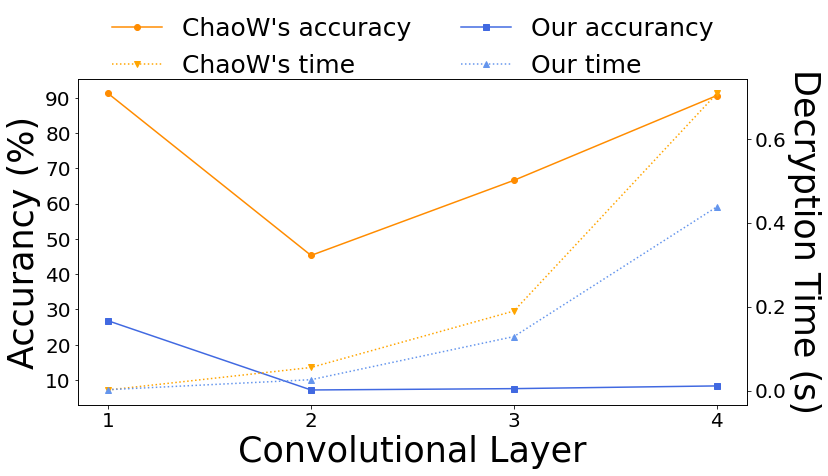

In [66]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
ax1.set_xlabel('Convolutional Layer',fontsize=35)
ax1.set_ylabel('Accurancy (%)',fontsize=35)
x=list(range(1,len(acm_acc_1)+1))
ax1.set_xticks(x)
ax1.set_yticks([10,20])

t=round(max(max(acm_time_1),max(backer_time_1))+0.5,1)
ax2.set_yticks(np.arange(0, t, 0.5))
print(np.arange(0, t, 0.1))
print(max(max(acm_time_1),max(backer_time_1)))
ax2.set_ylabel('Decryption Time (s)',rotation=-90,x=2,fontsize=35)
ax2.yaxis.set_label_coords(1.11,0.5)
ax1.set_xticklabels(layer_1)

l11,=ax1.plot(x,acm_acc_1,color='darkorange', marker='o' )
l12,=ax1.plot(x,backer_acc_1,color='royalblue', marker='s' )

# l11=ax1.bar(x, acm_acc_1, fc='lightgrey')
# l12=ax1.bar(x, backer_acc_1, fc='lightskyblue')

l21,=ax2.plot(x,acm_time_1,linestyle='dotted',color='orange', marker='v' )
l22,=ax2.plot(x,backer_time_1,linestyle='dotted', color='cornflowerblue',marker='^' )
ax1.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
ax1.legend(handles=[l11,l21,l12,l22], labels=['ChaoW\'s accuracy','ChaoW\'s time','Our accurancy','Our time'],borderaxespad = 0.,loc=9,bbox_to_anchor=(0.5,1.22),ncol=2,frameon=False,fontsize=25)
#ax1.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.) ##设置ax4中legend的位置，将其放在图外
ax1.set_ylim((0,20))
plt.savefig('./output/vgg16_cmp.pdf', dpi=300,bbox_inches = 'tight')
####################################################

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
ax1.set_xlabel('Convolutional Layer',fontsize=35)
ax1.set_ylabel('Accurancy (%)',fontsize=35)
x=list(range(1,len(acm_acc_2)+1))
ax1.set_xticks(x)
ax1.set_yticks(range(0,100,10))
t=round(max(max(acm_time_2),max(backer_time_2))+0.5,1)
ax2.set_yticks(np.arange(0.0, t, 0.2))
ax2.set_ylabel('Decryption Time (s)',rotation=-90,x=2,fontsize=35)
ax2.yaxis.set_label_coords(1.11,0.5)


l11,=ax1.plot(x,acm_acc_2,color='darkorange', marker='o' )
l12,=ax1.plot(x,backer_acc_2,color='royalblue', marker='s' )

# l11=ax1.bar(x, acm_acc_2, fc='lightgrey')
# l12=ax1.bar(x, backer_acc_2, fc='lightskyblue')

l21,=ax2.plot(x,acm_time_2,linestyle='dotted',color='orange', marker='v' )
l22,=ax2.plot(x,backer_time_2,linestyle='dotted', color='cornflowerblue',marker='^' )
ax1.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
ax1.legend(handles=[l11,l21,l12,l22], labels=['ChaoW\'s accuracy','ChaoW\'s time','Our accurancy','Our time'],borderaxespad = 0.,loc=9,bbox_to_anchor=(0.5,1.22),ncol=2,frameon=False,fontsize=25)
#ax1.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.) ##设置ax4中legend的位置，将其放在图外
#ax1.set_xticklabels(layer_2,fontsize=8)

plt.savefig('./output/vgg16_cmp2.pdf', dpi=300,bbox_inches = 'tight')

In [30]:
f = open('result_vgg16.txt' , 'w', encoding='gbk')
time_pro=[]
acc_pro=[]
time_pro_2=[]
acc_pro_2=[]
time_pro_avg=[]
acc_pro_avg=[]
for a in range(len(acm_time_1)):
    time_pro.append((acm_time_1[a]-backer_time_1[a])/acm_time_1[a])
    acc_pro.append((acm_acc_1[a]-backer_acc_1[a])/acm_acc_1[a])
time_pro_avg.append(round(sum(time_pro)/len(time_pro)*100,2))
acc_pro_avg.append(round(sum(acc_pro)/len(acc_pro)*100,2))


for a in range(len(acm_time_2)):
    time_pro_2.append((acm_time_2[a]-backer_time_2[a])/acm_time_2[a])
    acc_pro_2.append((acm_acc_2[a]-backer_acc_2[a])/acm_acc_2[a])
time_pro_avg.append(round(sum(time_pro_2)/len(time_pro_2)*100,2))
acc_pro_avg.append(round(sum(acc_pro_2)/len(acc_pro_2)*100,2))

print("time",time_pro_avg)
print("acc",acc_pro_avg)
f.write("time%:"+str(time_pro_avg)+"\n")
f.write("acc%:"+str(acc_pro_avg)+"\n")
f.flush()

time_pro=[]
acc_pro=[]
time_pro_2=[]
acc_pro_2=[]
time_pro_avg=[]
acc_pro_avg=[]
for a in range(len(acm_time_1)):
    time_pro.append((acm_time_1[a]-backer_time_1[a]))
    acc_pro.append((acm_acc_1[a]-backer_acc_1[a]))
time_pro_avg.append(round(sum(time_pro)/len(time_pro),2))
acc_pro_avg.append(round(sum(acc_pro)/len(acc_pro),2))


for a in range(len(acm_time_2)):
    time_pro_2.append((acm_time_2[a]-backer_time_2[a]))
    acc_pro_2.append((acm_acc_2[a]-backer_acc_2[a]))
time_pro_avg.append(round(sum(time_pro_2)/len(time_pro_2),2))
acc_pro_avg.append(round(sum(acc_pro_2)/len(acc_pro_2),2))

print("time",time_pro_avg)
print("acc",acc_pro_avg)

print("time",time_pro_avg)
print("acc",acc_pro_avg)
f.write("time:"+str(time_pro_avg)+"\n")
f.write("acc:"+str(acc_pro_avg)+"\n")
f.flush()


time [71.68, 18.31]
acc [33.25, 83.56]
time [1.21, 0.09]
acc [3.55, 60.98]
time [1.21, 0.09]
acc [3.55, 60.98]


In [31]:

f.write("layer_1="+str(layer_1)+'\n')
f.flush()
f.write("layer_2="+str(layer_2)+'\n')
f.flush()
f.write("acm_acc_1="+str(acm_acc_1)+'\n')
f.flush()
f.write("acm_acc_2="+str(acm_acc_2)+'\n')
f.flush()
f.write("acm_time_1="+str(acm_time_1)+'\n')
f.flush()
f.write("acm_time_2="+str(acm_time_2)+'\n')
f.flush()
f.write("backer_acc_1="+str(backer_acc_1)+'\n')
f.flush()
f.write("backer_acc_2="+str(backer_acc_2)+'\n')
f.flush()
f.write("backer_time_1="+str(backer_time_1)+'\n')
f.flush()
f.write("backer_time_2="+str(backer_time_2)+'\n')
f.flush()
f.close()